In [3]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display, Markdown, Latex

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [4]:
# gwas_gene_list = (
#     [f"top-{n}" for n in [100, 500, 1000, 2000]]
#     + [f"fwer5-{n}" for n in [1000, 2000]]
#     + [f"fdr1-{n}" for n in [1000, 2000]]
#     + [f"fdr5-{n}" for n in [1000, 2000]]
# )

gwas_gene_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fwer5-{n}" for n in [2000]]
    + [f"fdr1-{n}" for n in [2000]]
    + [f"fdr5-{n}" for n in [2000]]
)

gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_gene_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

In [5]:
df_plot = pd.read_csv("power-analysis.csv")

# normalize by the maximum statistics by trait, rep_i
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].max()
    df_plot_normalized.append(df_group)
df_plot_normalized = pd.concat(df_plot_normalized)

# then average across trait for each `method` and `rep_i`
df_plot = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()

In [6]:
df_plot["gwas_weight"] = df_plot["method"].apply(lambda x: x.split(".")[0])
df_plot["sc_weight"] = df_plot["method"].apply(lambda x: x.split(".")[1])

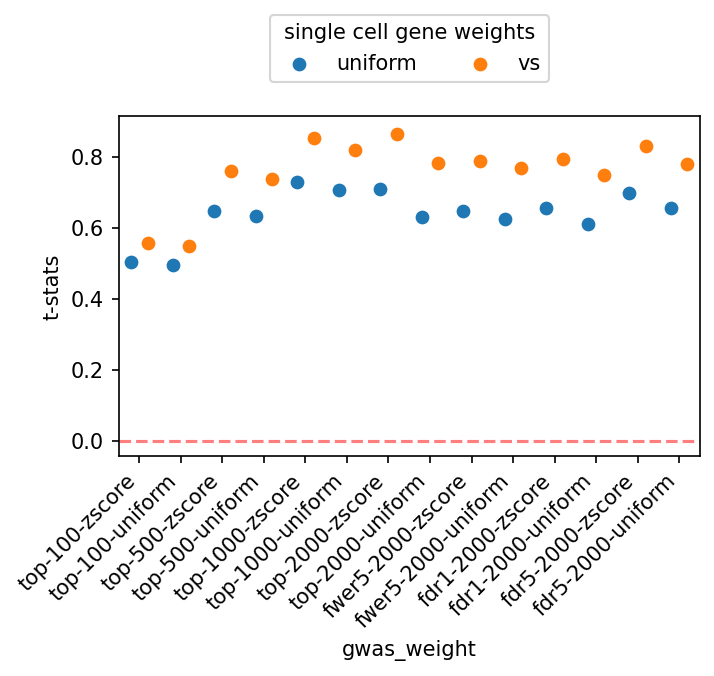

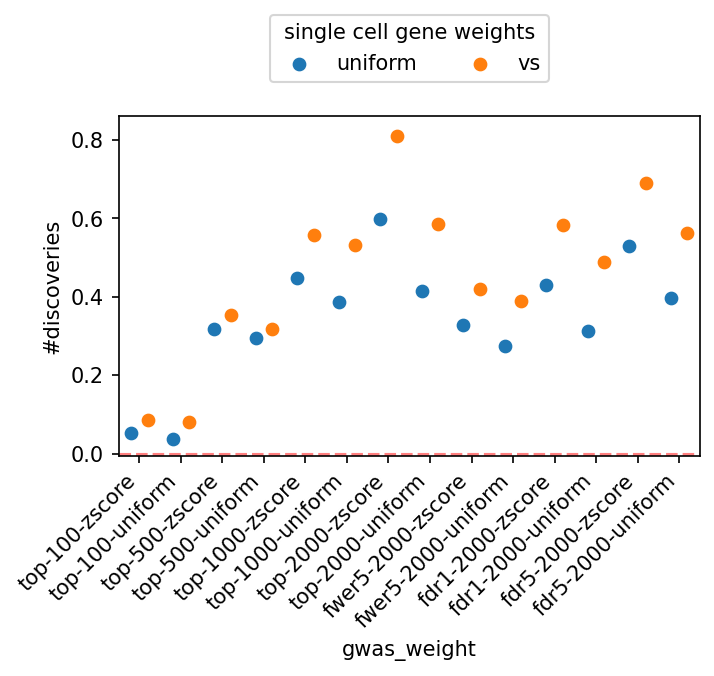

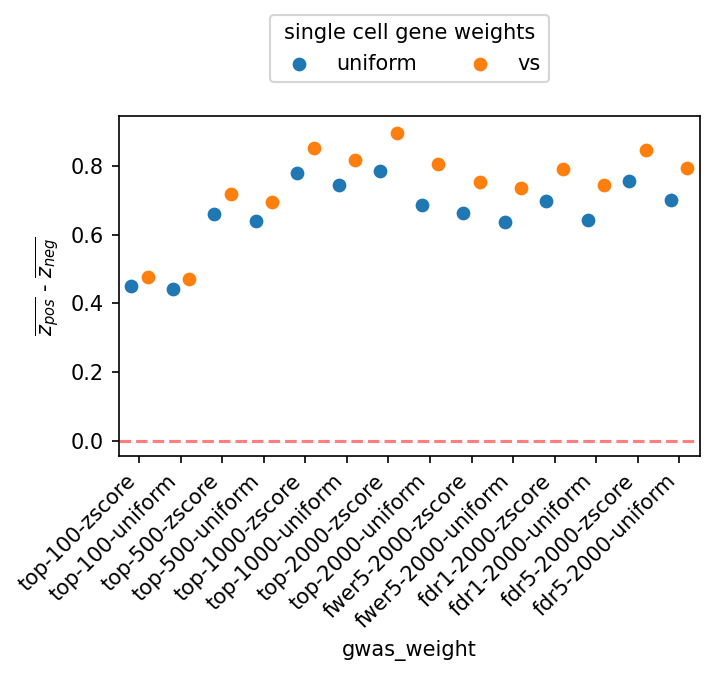

In [7]:
for y in ["tstats", "n_discovery", "meanshift"]:
    fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
    sns.pointplot(
        data=df_plot,
        x="gwas_weight",
        order=gwas_weight_list,
        y=y,
        hue="sc_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(
        loc="center",
        bbox_to_anchor=[0.5, 1.2],
        ncol=2,
        title="single cell gene weights",
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

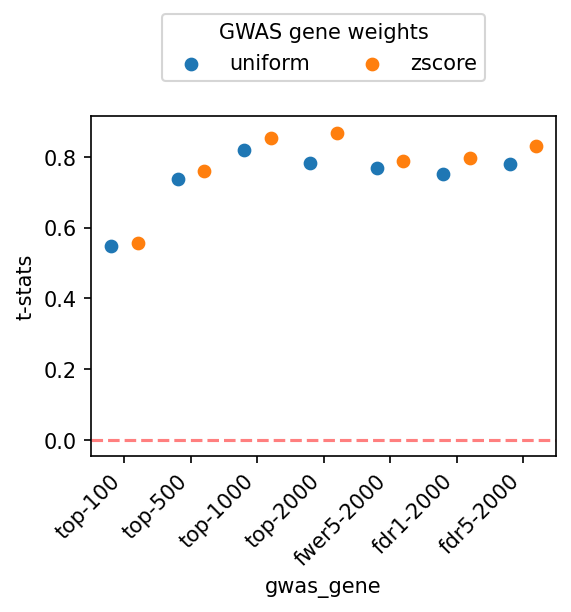

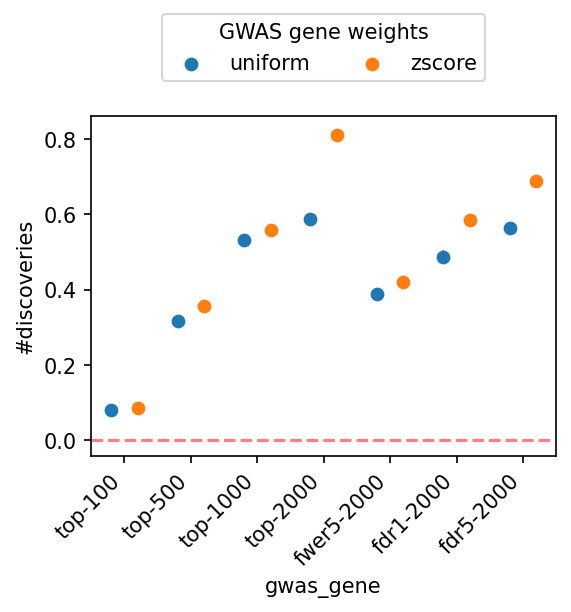

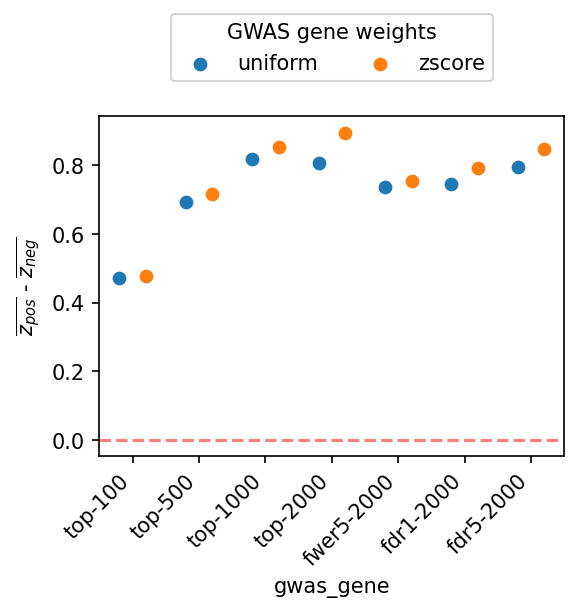

In [9]:
for y in ["tstats", "n_discovery", "meanshift"]:
    df_tmp = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])
    df_tmp["gwas_gene"] = df_tmp["gwas_weight"].apply(lambda x: x.rsplit("-", 1)[0])
    df_tmp["gwas_gene_weight"] = df_tmp["gwas_weight"].apply(
        lambda x: x.rsplit("-", 1)[1]
    )

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
    sns.pointplot(
        data=df_tmp,
        x="gwas_gene",
        y=y,
        order=gwas_gene_list,
        hue="gwas_gene_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(
        loc="center", bbox_to_anchor=[0.5, 1.2], ncol=2, title="GWAS gene weights"
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

# Numerical table for the results

In [17]:
df_plot = pd.read_csv("power-analysis.csv")

# normalize by the maximum statistics (across method) by trait, rep_i
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].max()
    df_plot_normalized.append(df_group)
df_plot = pd.concat(df_plot_normalized)

# # then meta-analyze across traits for each `method` and `rep_i`
# df_mean = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()
# df_sem = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()

# for df_tmp in [df_mean, df_sem]:
#     df_tmp["gwas_selection"] = df_tmp["method"].apply(
#         lambda x: x.split(".")[0].rsplit("-", 1)[0]
#     )
#     df_tmp["gwas_weight"] = df_tmp["method"].apply(
#         lambda x: x.split(".")[0].rsplit("-", 1)[1]
#     )
#     df_tmp["sc_weight"] = df_tmp["method"].apply(lambda x: x.split(".")[1])

In [11]:
dict_df_res = {m: dict() for m in ["n_discovery", "tstats", "meanshift"]}

for trait in df_plot.trait.unique():
    df_plot_trait = df_plot[df_plot.trait == trait].copy()

    df_plot_trait["gene_selection"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[0]
    )
    df_plot_trait["gwas_weight"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[1]
    )
    df_plot_trait["sc_weight"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[1]
    )

    for metric in ["tstats", "meanshift", "n_discovery"]:
        df_tmp = (
            df_plot_trait.groupby(["gene_selection", "gwas_weight", "sc_weight"])
            .apply(lambda x: x[metric].mean())
            .unstack(level=0)
        ).reset_index()
        df_tmp.columns.name = None
        df_tmp = df_tmp.set_index(["gwas_weight", "sc_weight"])[gwas_gene_list]
        dict_df_res[metric][trait] = df_tmp
#     display(Markdown(f"## {trait}"))
#     display(df_tmp.style.highlight_quantile(color="yellow", axis=None, q_left=0.85))

In [19]:
df_tstats_avg = None
for trait in dict_df_res["tstats"]:
    df_tmp = dict_df_res["tstats"][trait]
    if df_tstats_avg is None:
        df_tstats_avg = df_tmp
    else:
        df_tstats_avg += df_tmp
df_tstats_avg /= len(dict_df_res["tstats"])

with pd.option_context("display.precision", 3):
    display(
        df_tstats_avg.style.bar(axis=None, vmin=0, vmax=1.0).set_properties(
            **{"color": "black !important", "border": "2px black solid !important"}
        )
    )

In [21]:
df_ndisc_avg = None
for trait in dict_df_res["n_discovery"]:
    df_tmp = dict_df_res["n_discovery"][trait]
    if df_ndisc_avg is None:
        df_ndisc_avg = df_tmp
    else:
        df_ndisc_avg += df_tmp
df_ndisc_avg /= len(dict_df_res["n_discovery"])

with pd.option_context("display.precision", 3):
    display(
        df_ndisc_avg.style.bar(axis=None, vmin=0, vmax=1.0).set_properties(
            **{"color": "black !important", "border": "2px black solid !important"}
        )
    )